In [1]:
import os
import time
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
from catanatron_gym.envs.catanatron_env import ACTION_SPACE_SIZE
from catanatron_gym.features import get_feature_ordering

2022-01-27 15:29:52.646137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 15:29:52.646160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ===== Ensure datasets exists
import pathlib
import urllib.request

# Set appropriately in cloud environments
DOWNLOAD_FROM_INTERNET = False
DATA_FOLDER = "../../../data/vf-action-type-prediction"
VALIDATION_DATA = DATA_FOLDER + '-validation'

DATASET_PATH = pathlib.Path(DATA_FOLDER, "main.csv.gzip")
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA, "main.csv.gzip")

if DOWNLOAD_FROM_INTERNET:
    DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    VALIDATION_DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    if not DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard/main.csv.gzip", DATASET_PATH)
    if not VALIDATION_DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard-validation/main.csv.gzip", VALIDATION_DATASET_PATH)

In [3]:
import gzip

ACTIONS_DATASET_PATH = pathlib.Path(DATASET_PATH, "actions.csv.gzip")
NUM_SAMPLES = 0
with gzip.open(ACTIONS_DATASET_PATH, "r") as f:
    for _ in f:
        NUM_SAMPLES += 1
print(NUM_SAMPLES, "samples")

165226


In [4]:
data = pd.read_csv(DATASET_PATH, nrows=10, compression='gzip')
validation_data = pd.read_csv(VALIDATION_DATASET_PATH, nrows=10, compression='gzip')

assert (data.columns == validation_data.columns).all()
data

,F_BANK_BRICK,F_BANK_DEV_CARDS,F_BANK_ORE,F_BANK_SHEEP,F_BANK_WHEAT,F_BANK_WOOD,"F_EDGE(0, 1)_P0_ROAD","F_EDGE(0, 1)_P1_ROAD","F_EDGE(0, 20)_P0_ROAD","F_EDGE(0, 20)_P1_ROAD",...,F_TILE9_IS_WHEAT,F_TILE9_IS_WOOD,F_TILE9_PROBA,ACTION,ACTION_TYPE,RETURN,DISCOUNTED_RETURN,TOURNAMENT_RETURN,DISCOUNTED_TOURNAMENT_RETURN,VICTORY_POINTS_RETURN
0,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,106,4,0.0,0.0,5.0,2.30611,4.961646
1,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,45,3,0.0,0.0,5.0,2.30611,4.961646
2,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,114,4,0.0,0.0,5.0,2.30611,4.961646
3,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,51,3,0.0,0.0,5.0,2.30611,4.961646
4,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,0.0,0.0,5.0,2.30611,4.961646
5,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,0.0,0.0,5.0,2.30611,4.961646
6,17.0,25.0,18.0,18.0,16.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,0.0,0.0,5.0,2.30611,4.961646
7,17.0,25.0,18.0,18.0,16.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,289,12,0.0,0.0,5.0,2.30611,4.961646
8,17.0,25.0,17.0,18.0,12.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0,0,0.0,0.0,5.0,2.30611,4.961646
9,17.0,25.0,17.0,18.0,16.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,241,11,0.0,0.0,5.0,2.30611,4.961646


In [5]:
# ===== Read Dataset
BATCH_SIZE = 128
SHUFFLE_SEED = 1
INPUT_COLUMNS = list(filter(lambda x: x.startswith("F_"), data.columns))
LABEL_COLUMN = "ACTION_TYPE"
OUTPUT_SIZE = 13

dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,  # shuffle will shuffle at the element level. nice.
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)
validation_dataset = tf.data.experimental.make_csv_dataset(
    str(VALIDATION_DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)

def preprocess(batch, label):
    features = tf.stack(
        [tf.cast(tensor, tf.float32) 
         for feature_name, tensor in batch.items() 
         if feature_name in INPUT_COLUMNS
        ], axis=1
    )
    return features, tf.stack(label)

dataset = dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

2022-01-27 15:29:57.527202: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-27 15:29:57.588526: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-27 15:29:57.588561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcollazo-Erazer-X510): /proc/driver/nvidia/version does not exist
2022-01-27 15:29:57.588976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# 100 batches take 7 secs. 1000 takes 75 secs.
t1 = time.time()
def take_samples(x, y):
    return x

normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
normalization_layer.adapt(dataset.map(take_samples).take(1000))
print("Normalization took:", time.time() - t1)

Normalization took: 76.33301043510437


In [28]:
# ===== Build Class Weights
labels_dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=[LABEL_COLUMN],
    compression_type="GZIP",
)
def count(counts, batch):
    features, labels = batch
    for i in range(OUTPUT_SIZE):
        class_i = labels == i
        class_i = tf.cast(class_i, tf.int32)
        counts[f"class_{i}"] += tf.reduce_sum(class_i)
    return counts

# This takes abount 3mins
start = time.time()
initial_state = {f"class_{i}": 0 for i in range(OUTPUT_SIZE)}
counts = labels_dataset.reduce(initial_state=initial_state, reduce_func=count)  # { "class_0": tf.Tensor, ... }
print("Computing class counts took:", time.time() - start, "seconds")

Computing class counts took: 28.67038917541504 seconds


In [29]:
counts_array = np.array([counts[f"class_{i}"].numpy() for i in range(OUTPUT_SIZE)]).astype(np.float32)

fractions = counts_array/counts_array.sum()
weights = (1 / counts_array) * (counts_array.sum() / OUTPUT_SIZE)
weights[weights == np.inf] = -np.inf  # Drop inf to min value (to sort of "clip" importance)
weights[weights == -np.inf] = np.max(weights)  # Drop inf to min value (to sort of "clip" importance)
class_weight = {i: weights[i] for i in range(OUTPUT_SIZE)}
pprint(class_weight)

# {0: 0.010215329, then many in 0.5-2 range, 289: 0.010377976}

# === Rejection Resampling
# def class_func(features, label):
#     return label
# n = ACTION_SPACE_SIZE
# target_dist = [1.0 / n for i in range(n)]
# resampler = tf.data.experimental.rejection_resample(
#     class_func, target_dist=target_dist)

# dataset = dataset.unbatch().apply(resampler).batch(BATCH_SIZE)\
#     .map(lambda extra_label, features_and_label: features_and_label)
# dataset

{0: 0.22412097,
 1: 1.2586013,
 2: 4.0140452,
 3: 0.8320092,
 4: 1.6432182,
 5: 3.9167526,
 6: 8.010752,
 7: 18.287987,
 8: 95.803856,
 9: 106.405106,
 10: 106.405106,
 11: 1.2025032,
 12: 0.22738989}


/tmp/ipykernel_334489/166635234.py:4: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1 / counts_array) * (counts_array.sum() / OUTPUT_SIZE)


In [61]:
# Things to try: Dropout. Less Learning Rate. Simpler Models. Validation Graph.
INPUT_SHAPE = (len(INPUT_COLUMNS),)
LAYERS = [128, 128, 128]

inputs = tf.keras.Input(shape=INPUT_SHAPE)

last_layer = inputs
last_layer = normalization_layer(last_layer)
for num_neurons in LAYERS:
    last_layer = tf.keras.layers.Dense(num_neurons, activation="tanh", dtype='float64')(last_layer)

last_layer = tf.keras.layers.Dropout(0.2)(last_layer)
output_dense = tf.keras.layers.Dense(13, dtype='float64')(last_layer)
model = tf.keras.Model(inputs=inputs, outputs=output_dense)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['categorical_accuracy', 'accuracy', 'sparse_categorical_accuracy']
)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 614)]             0         
_________________________________________________________________
normalization_13 (Normalizat (None, 614)               3         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               78720     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 13)                1677

In [ ]:
# class_weight = {i: 1 for i in range(290)}
# class_weight[0] = 0.01
# class_weight[289] = 0.01
# class_weight[0] = 0.1
# class_weight[289] = 0.1

history = model.fit(
    dataset, 
    epochs=10,
    # steps_per_epoch=10,
    # validation_steps=10,
    validation_data=validation_dataset,
    class_weight=class_weight
)

Epoch 1/10
   1187/Unknown - 114s 95ms/step - loss: 98.0755 - categorical_accuracy: 0.0843 - accuracy: 0.0816 - sparse_categorical_accuracy: 0.0816

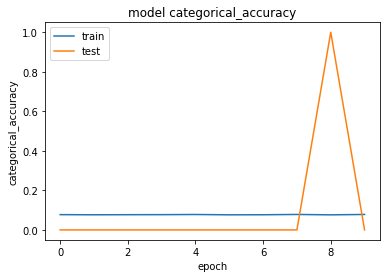

In [57]:
# summarize history for categorical_accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'sparse_categorical_accuracy'

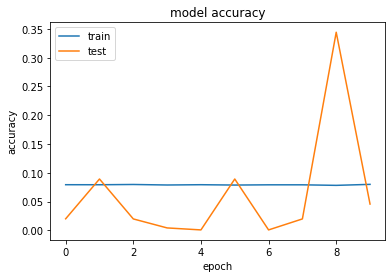

In [59]:
# summarize history for categorical_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

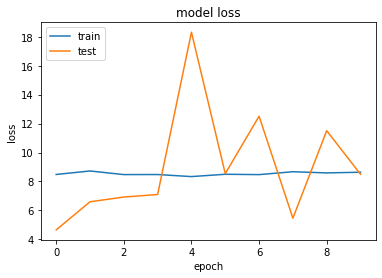

In [60]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("data/models/vf-action-type-prediction-model")

In [44]:
from pprint import pprint
import random
import numpy as np
import tensorflow as tf

from catanatron.game import Game
from catanatron.models.player import Player, RandomPlayer, Color
from catanatron.models.enums import ActionType
from catanatron.players.weighted_random import WeightedRandomPlayer
from catanatron_experimental.play import play_batch
from catanatron_gym.envs.catanatron_env import to_action_space, ACTION_SPACE_SIZE, from_action_space
from catanatron_gym.features import create_sample_vector, create_sample


action_types = [i for i in ActionType]


def to_action_type_space(action):
    return action_types.index(action.action_type)


class MyPlayer(Player):
    def decide(self, game, playable_actions):
        """Should return one of the playable_actions.

        Args:
            game (Game): complete game state. read-only.
            playable_actions (Iterable[Action]): options to choose from
        Return:
            action (Action): Chosen element of playable_actions
        """
        # ===== YOUR CODE HERE =====
        action_type_ints = [to_action_type_space(a) for a in playable_actions]
        mask = np.zeros(13, dtype=np.float)
        mask[action_type_ints] = 1
        mask[mask == 0] = np.nan

        # Get action probabilities with neural network.
        vector = create_sample_vector(game, self.color)
        record = create_sample(game, self.color)
        keys = [name[2:] for name in INPUT_COLUMNS] # remove the F_ prefix
        vector = [record[x] for x in keys]
        return playable_actions[0]
        X = [vector]
        result = model.call(tf.convert_to_tensor(X))

        # Multiply mask with output, and take max.
        clipped_probabilities = np.multiply(mask, result[0])
        clipped_probabilities[np.isnan(clipped_probabilities)] = -np.inf
        action_type_index = np.argmax(clipped_probabilities)
        predicted_action_type = action_types[action_type_index]
        
        actions_of_predicted_type = list(filter(
            lambda a: a.action_type == predicted_action_type, 
            playable_actions))
        return random.choice(actions_of_predicted_type)
        # ===== END YOUR CODE =====

import importlib
import catanatron_experimental.play #import the module here, so that it can be reloaded.
importlib.reload(catanatron_experimental.play)
        
# Play a simple 4v4 game. Edit MyPlayer with your logic!
players = [
    MyPlayer(Color.RED),
    RandomPlayer(Color.WHITE),
]
wins, results_by_player, games = play_batch(5, players)

pprint(wins)
pprint(results_by_player)

# Results: [64, 32, 32] with LR 1e-4 made a bot that won 60% of games against Random. Had %60 categorical accuracy.

Output()

                     Last 5 Games                     
    ╷           ╷       ╷        ╷          ╷         
  # │ SEATING   │ TURNS │ RED VP │ WHITE VP │ WINNER  
╶───┼───────────┼───────┼────────┼──────────┼────────╴
  1 │ RED,WHITE │   455 │      2 │       10 │ WHITE   
  2 │ WHITE,RED │   208 │      2 │       11 │ WHITE   
  3 │ RED,WHITE │   333 │      2 │       10 │ WHITE   
  4 │ RED,WHITE │   463 │      2 │       10 │ WHITE   
  5 │ RED,WHITE │   761 │      2 │       10 │ WHITE   
    ╵           ╵       ╵        ╵          ╵

                                       Player Summary                                        
                     ╷      ╷        ╷          ╷          ╷          ╷          ╷           
                     │      │        │      AVG │      AVG │          │          │  AVG DEV  
                     │ WINS │ AVG VP │  SETTLES │   CITIES │ AVG ROAD │ AVG ARMY │       VP  
╶────────────────────┼──────┼────────┼──────────┼──────────┼──────────┼──────────┼──────────╴
  MyPlayer:RED       │    0 │   2.00 │     2.00 │     0.00 │     0.00 │     0.00 │     0.00  
  RandomPlayer:WHITE │    5 │  10.20 │     4.00 │     0.40 │     1.00 │     0.80 │     1.80  
                     ╵      ╵        ╵          ╵          ╵          ╵          ╵

              Game Summary              
            ╷           ╷               
  AVG TICKS │ AVG TURNS │ AVG DURATION  
╶───────────┼───────────┼──────────────╴
    1079.40 │    444.00 │   0.317 secs  
            ╵           ╵

{<Color.RED: 'RED'>: 0, <Color.WHITE: 'WHITE'>: 5}
{<Color.RED: 'RED'>: [2, 2, 2, 2, 2],
 <Color.WHITE: 'WHITE'>: [10, 11, 10, 10, 10]}
